In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import os, pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (mean_squared_error, accuracy_score, confusion_matrix, precision_score,
                              roc_auc_score, recall_score, f1_score, precision_recall_curve,
                                average_precision_score, ConfusionMatrixDisplay, auc, roc_curve)
import xgboost as xgb

features = pd.read_csv("../data/processed/features.csv")
target = pd.read_csv("../data/processed/target.csv").to_numpy().ravel()

# Split train and test sets: keep 20% for test and remaining 80% for train & validation
X_temp, X_test, y_temp, y_test = train_test_split(
    features, target,
    test_size=0.2,
    stratify=target,
    random_state=422,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    stratify=y_temp,
    random_state=422,
    shuffle=True
)

# Get categorical and numeric variables/ columns
numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

# Create a preprocessor: Scale data and create dummies
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(drop="first"), categorical_cols)
])

# Define function to automate model evaluation process
def evaluate_model(name, y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "model":        name,
        "mse":          mean_squared_error(y_true, y_pred),
        "accuracy":     accuracy_score(y_true, y_pred),
        "precision":    precision_score(y_true, y_pred),
        "recall":       recall_score(y_true, y_pred),
        "f1":           f1_score(y_true, y_pred),
        "roc_auc":      roc_auc_score(y_true, y_pred),
        "tn":           tn,    # true negatives
        "fp":           fp,    # false positives
        "fn":           fn,    # false negatives
        "tp":           tp     # true positives
    }

In [59]:
# Set pipeline 
pipe = Pipeline([
    ("preproc", preprocessor),
    ("model", DecisionTreeClassifier())
])

# Set parameter grid for three models
param_grid = [
    {
    "model": [DecisionTreeClassifier()],   # Decision Tree Classifier
    "model__max_depth": [5, 15, 25],
    "model__min_samples_split": [20, 30, 40],
    "model__min_samples_leaf": [5, 10, 20],
    "model__max_features": [None, "log2", "sqrt"],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight": ["balanced"]
    },
    {
    "model": [LogisticRegression()],
    "model__C": [0.01, 0.1, 0.3],
    "model__class_weight": ["balanced"],
    "model__penalty": ["l1", "l2", None],
    "model__solver": ["liblinear", "lbfgs"]
    },
    {
     "model": [xgb.XGBClassifier(tree_method="hist")],  # Boosted Decision Tree Classifier
     "model__n_estimators":[50, 100, 150],
     "model__max_depth":[5, 10, 15],
     "model__max_leaves": [10, 30, 50],
    },
    {"model": [RandomForestClassifier()],   # Random Forest Classifier
      "model__max_depth": [None, 10, 20],
      "model__min_samples_split": [50, 60, 70],
      "model__min_samples_leaf": [30, 40, 50],
      "model__max_features": [None, "log2", "sqrt"],
      "model__criterion": ["gini", "entropy"],
      "model__class_weight": ["balanced"]
    }
]
    
# Set and train grid search 
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid.fit(X_train, y_train)


/home/rafaelconde/Programing/Python/Projects/LoanDataAnalysis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/rafaelconde/Programing/Python/Projects/LoanDataAnalysis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/rafaelconde/Programing/Python/Projects/LoanDataAnalysis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/rafaelconde/Programing/Python/Projects/LoanDataAnalysis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/rafaelconde/Programing/Python/Projects/LoanDataAnalysis/.venv/lib/python3.

,estimator,Pipeline(step...lassifier())])
,param_grid,"[{'model': [DecisionTreeClassifier()], 'model__class_weight': ['balanced'], 'model__criterion': ['gini', 'entropy'], 'model__max_depth': [5, 15, ...], ...}, {'model': [LogisticRegression()], 'model__C': [0.01, 0.1, ...], 'model__class_weight': ['balanced'], 'model__penalty': ['l1', 'l2', ...], ...}, ...]"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [98]:
res = pd.DataFrame(grid.cv_results_)

# The most useful columns
cols = [
    "rank_test_score",      # 1 = best
    "mean_test_score",      # mean of cv folds
    "std_test_score",       # std-dev across folds
    "mean_fit_time",
    "param_model",          # which base estimator
]

res["param_model_str"] = res["param_model"].astype(str)

# nicer view: sort by the CV score
all_scores = res[cols].sort_values("rank_test_score")
all_scores['param_model'] = all_scores['param_model'].astype(str)

# Keep only the best configuration for each unique model
top_models = all_scores.groupby("param_model", as_index=False).first().sort_values(by="rank_test_score")
top_models["param_model"] = top_models["param_model"].str.split("(").str[0]

In [61]:
# Best estimator
best_estimator = grid.best_estimator_

# Print metrics for training, validation and testing data sets
print(f"Training score: {best_estimator.score(X_train, y_train)}")
print(f"Validation score: {best_estimator.score(X_val, y_val)}")
print(f"Test score: {best_estimator.score(X_test, y_test)}")

# Pring best parameter (and model)
print(f"Best parameters:  {grid.best_params_}")


Training score: 0.6334841628959276
Validation score: 0.622651356993737
Test score: 0.627348643006263
Best parameters:  {'model': LogisticRegression(), 'model__C': 0.3, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'model__solver': 'liblinear'}


In [62]:
# Compute prediction for testing and validation data sets
y_val_pred = best_estimator.predict(X_val)
y_test_pred = best_estimator.predict(X_test)

# Compute evaluation metrics for validation data set
val_results= evaluate_model(grid.best_params_["model"], y_val, y_val_pred)
val_results["split"] = "validation"

# Compute evaluation metrics for test data set
test_results = evaluate_model(grid.best_params_["model"], y_test, y_test_pred)
test_results["split"] = "test"

# Combine test and validation metrics
metrics_df = (
    pd.DataFrame([val_results, test_results])
      .set_index(["model","split"])
)

rf = best_estimator.named_steps["model"]
if rf == "RandomForest()":
  imps = rf.feature_importances_
  feature_names = X_train.columns
  feat_imp = pd.Series(imps, index=feature_names).sort_values(ascending=False)
  feat_imp.plot.bar()
  plt.ylabel("Feature Importance (%)")
  plt.xticks()
  plt.xlabel("Feature")
  plt.title(f"{grid.best_params_["model"]} Feature Importance")

metrics_df

mse  accuracy  precision    recall  \
model                split                                                 
LogisticRegression() validation  0.377349  0.622651   0.219677  0.530945   
                     test        0.372651  0.627349   0.232589  0.576547   

                                       f1   roc_auc    tn   fp   fn   tp  
model                split                                                
LogisticRegression() validation  0.310772  0.585547  1030  579  144  163  
                     test        0.331461  0.606794  1025  584  130  177

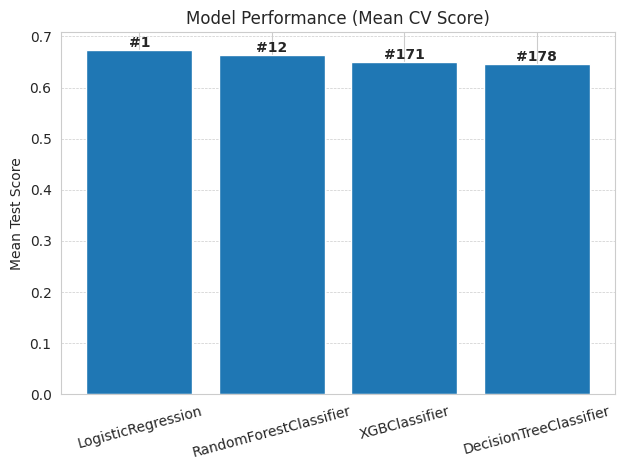

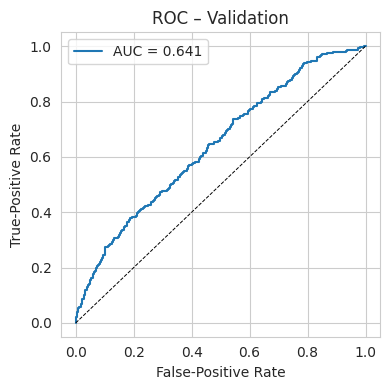

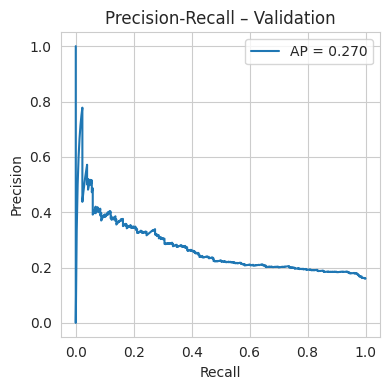

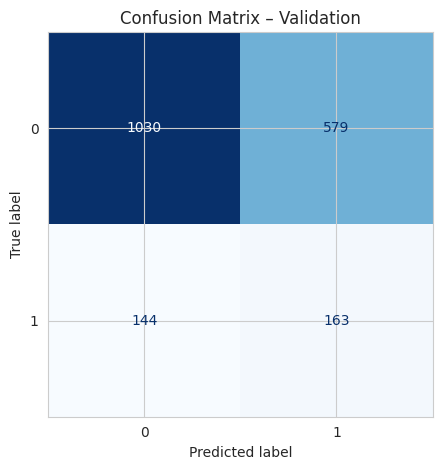

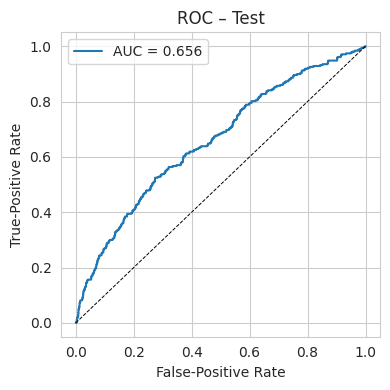

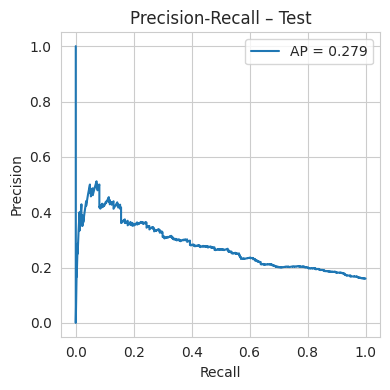

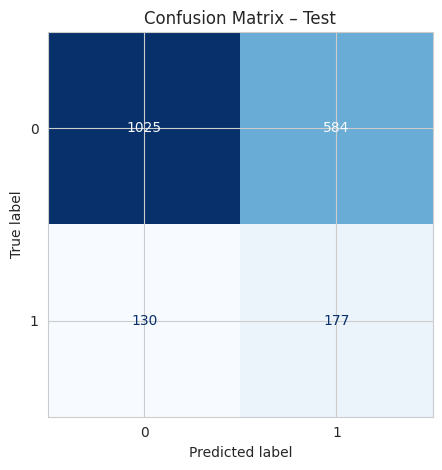

In [ ]:
# Where to save artefacts
fig_dir = pathlib.Path("../reports/figures/evaluation")
fig_dir.mkdir(parents=True, exist_ok=True)

# Plot best model of each on of the models in grid search
# First of each instance for each estimator
bars = plt.bar(top_models["param_model"], top_models["mean_test_score"])

for bar, rank in zip(bars, top_models["rank_test_score"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'#{rank}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.ylabel("Mean Test Score")
plt.title("Model Performance (Mean CV Score)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig(fig_dir / f"model_performance_rank.png", dpi=300)
plt.show()


# Grab feature names 
preprocessor = best_estimator.named_steps["preproc"]
feature_names = best_estimator.named_steps["preproc"].get_feature_names_out()

def roc_pr_plots(X, y, split_label):
    proba = best_estimator.predict_proba(X)[:,1]
    
    # ROC
    fpr, tpr, _   = roc_curve(y, proba)
    roc_auc       = auc(fpr, tpr)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],"k--",lw=0.7)
    plt.xlabel("False-Positive Rate"); plt.ylabel("True-Positive Rate")
    plt.title(f"ROC – {split_label}"); plt.legend()
    plt.tight_layout()
    plt.savefig(fig_dir / f"roc_{split_label.lower()}.png", dpi=300)
    plt.show()
    plt.close()
    
    # PR
    prec, rec, _  = precision_recall_curve(y, proba)
    ap            = average_precision_score(y, proba)
    plt.figure(figsize=(4,4))
    plt.plot(rec, prec, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision-Recall – {split_label}"); plt.legend()
    plt.tight_layout()
    plt.savefig(fig_dir / f"pr_{split_label.lower()}.png", dpi=300)
    plt.show()
    plt.close()
    
    # Confusion matrix
    cm  = confusion_matrix(y, (proba>=0.5))
    disp= ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues", colorbar=False)
    plt.title(f"Confusion Matrix – {split_label}")
    plt.tight_layout()
    plt.savefig(fig_dir / f"confmat_{split_label.lower()}.png", dpi=300)
    plt.show()
    plt.close()

roc_pr_plots(X_val,  y_val,  "Validation")
roc_pr_plots(X_test, y_test, "Test")